# Example 3: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

In [1]:
import sys
sys.path.append('../')

In [2]:
from kan import KAN

create the two moon dataset

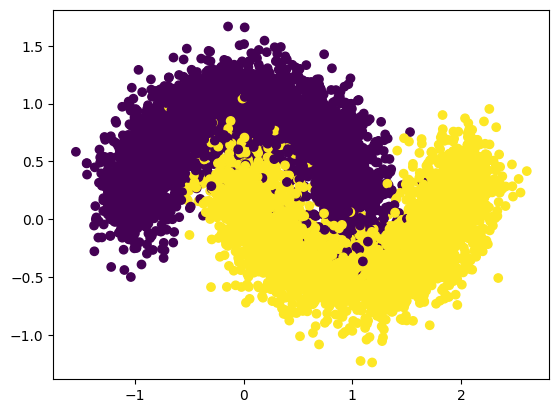

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=7000, shuffle=True, noise=0.2, random_state=None)
test_input, test_label = make_moons(n_samples=3000, shuffle=True, noise=0.2, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)
dataset['train_label'] = torch.from_numpy(train_label[:,None])
dataset['test_label'] = torch.from_numpy(test_label[:,None])

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:,0])

Train KAN

In [4]:
model = KAN(width=[2,2,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=200, metrics=(train_acc, test_acc), lr=0.0002)
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.66e-01 | test loss: 1.62e-01 | reg: 6.49e+00 : 100%|██| 20/20 [00:42<00:00,  2.11s/it]


(0.9674285650253296, 0.9693333506584167)

Automatic symbolic regression

In [6]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
# model.auto_symbolic(lib=lib)
model.auto_symbolic()
formula = model.symbolic_formula()[0][0]
formula

fixing (0,0,0) with sin, r2=0.9983997892209227
fixing (0,0,1) with sin, r2=0.943778579929036
fixing (0,1,0) with gaussian, r2=0.9997423220339415
fixing (0,1,1) with gaussian, r2=0.9997385849286238
fixing (1,0,0) with tanh, r2=0.9939953650833994
fixing (1,1,0) with gaussian, r2=0.9949860394674711


0.52*tanh(4.04*sin(0.97*x_1 - 7.59) + 3.08 - 3.87*exp(-1.07*(0.62 - x_2)**2)) + 0.49 + 1.08*exp(-38.36*(0.2*sin(2.17*x_1 + 7.6) - 1 + 0.85*exp(-0.35*(-x_2 - 0.31)**2))**2)

How accurate is this formula?

In [7]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9643)
test acc of the formula: tensor(0.9650)


In [8]:
results = model.train(dataset, opt="LBFGS", steps=30, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]

train loss: 1.64e-01 | test loss: 1.61e-01 | reg: 7.68e+00 : 100%|██| 30/30 [01:21<00:00,  2.71s/it]


(0.9658571481704712, 0.968666672706604)

In [9]:
formula = model.symbolic_formula()[0][0]
formula

0.51*tanh(64.23*sin(0.17*x_1 - 7.57) + 60.61 - 5.68*exp(-1.43*(0.53 - x_2)**2)) + 0.49 + 1.05*exp(-27.84*(0.31*sin(1.92*x_1 + 7.73) - 1 + 0.75*exp(-0.61*(-x_2 - 0.18)**2))**2)